# Machine Learning with The Titanic Dataset
by pou426 (github.com/pou426)

In [346]:
import pandas as pd
import numpy as np

# visualisation
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.ensemble import RandomForestRegressor

In [347]:
train_df = pd.read_csv('input/train.csv')
test_df = pd.read_csv('input/test.csv')
combine_df = [train_df, test_df]

## 1. Describe data

Features in dataset: https://www.kaggle.com/c/titanic/data

The data has been split into a training set and a testing set.

#### Data Dictionary
|Variable|Definition|Key|
|--------|----------|---|
|survival|Survival  |0 = No, 1 = Yes|
|pclass  |Ticket class|1 = 1st, 2 = 2nd, 3 = 3rd|
|sex     |Sex|   |
|Age     |Age in years|  |
|sibsp   |# of siblings / spouses aboard the Titanic|  |
|parch   |# of parents / children aboard the Titanic|  |
|ticket  |Ticket number|  |
|fare    |Passenger fare|  |
|cabin   |Cabin number|  |
|embarked|Port of Embarkation|C = Cherbourg, Q = Queenstown, S = Southampton|

#### Variable notes

<b>pclass</b>: A proxy for socio-economic status (SES)

|pclass|SES|
|------|---|
|1st|Upper|
|2nd|Middle|
|3rd|Lower|

<b>age</b>: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

<b>sibsp</b>: The dataset defines family relations in this way...

Sibling = brother, sister, stepbrother, stepsister<br>
Spouse = husband, wife (mistresses and fiancés were ignored)

<b>parch</b>: The dataset defines family relations in this way...

Parent = mother, father<br>
Child = daughter, son, stepdaughter, stepson<br>
Some children travelled only with a nanny, therefore parch=0 for them.

In [348]:
print('training set shape: '+str(train_df.shape))
print('testing set shape: '+str(test_df.shape))
train_df.describe()
# missing data in Age 

training set shape: (891, 12)
testing set shape: (418, 11)


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [349]:
train_df.describe(include=['O']) 
# two missing values in embarked

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Graham, Mr. George Edward",male,CA. 2343,C23 C25 C27,S
freq,1,577,7,4,644


In [350]:
# print (train_df.columns.values)

In [351]:
# inspect the data
train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 1.1 Pivoting features

In [352]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

pclass_df = train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)
sex_df = train_df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)
sibsp_df = train_df[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)
parch_df = train_df[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)
display_side_by_side(pclass_df, sex_df, sibsp_df, parch_df)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363
,Sex,Survived
0,female,0.742038
1,male,0.188908
,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395


In [353]:
print 'The number of samples for each number of Parch:'
temp = train_df.Parch.value_counts()
for i, t in enumerate(temp):
    print 'number of samples = {}, number of Parch = {}'.format(i, t)

The number of samples for each number of Parch:
number of samples = 0, number of Parch = 678
number of samples = 1, number of Parch = 118
number of samples = 2, number of Parch = 80
number of samples = 3, number of Parch = 5
number of samples = 4, number of Parch = 5
number of samples = 5, number of Parch = 4
number of samples = 6, number of Parch = 1


Pclass, Sex and SibSp all exhibition some kind of correlation while there is none in Parch. The number of samples we have for Parch > 5 is too small and thus not representative.

## 2. Feature Engineering 
### 2.1 Feature Engineering with SibSp and Parch
To combine SibSp and Parch into a new variable FamilySize

In [354]:
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1
test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch'] + 1

train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


In [355]:
train_df[['FamilySize','Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived',ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [356]:
print 'The number of samples for each number of FamilySize:'
fam_temp = train_df.FamilySize.value_counts()
for i, t in enumerate(fam_temp):
    print 'number of samples = {}, number of FamilySize = {}'.format(i, t)

The number of samples for each number of FamilySize:
number of samples = 0, number of FamilySize = 537
number of samples = 1, number of FamilySize = 161
number of samples = 2, number of FamilySize = 102
number of samples = 3, number of FamilySize = 29
number of samples = 4, number of FamilySize = 22
number of samples = 5, number of FamilySize = 15
number of samples = 6, number of FamilySize = 12
number of samples = 7, number of FamilySize = 7
number of samples = 8, number of FamilySize = 6


<div style="color:red">Is the difference between the number of samples for different FamilySize's too big?</div>

### 2.2 Feature Engineering with Name
Convert Name to Title, grouped by type.

In [357]:
for dataset in combine_df:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [358]:
for dataset in combine_df:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
                                                 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [359]:
print 'The number of samples for each Title:'
title_temp = train_df.Title.value_counts()
for i, t in enumerate(title_temp):
    print 'number of samples = {}, Title = {}'.format(i, t)

The number of samples for each Title:
number of samples = 0, Title = 517
number of samples = 1, Title = 185
number of samples = 2, Title = 126
number of samples = 3, Title = 40
number of samples = 4, Title = 23


### 2.3 Convert Categorical to Numerical Values
This allows classification with random forest, etc...
#### 2.3.1 Title Mapping

In [360]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine_df:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,1


#### 2.3.2 Sex Mapping

In [361]:
for dataset in combine_df:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Title
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,2,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,2,3
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,2,3
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,1,1


#### 2.3.3 Embarked Mapping
There are missing data, mapping will be done once Embarked is populated in section 3.1.

In [362]:
# for dataset in combine_df:
#     dataset['Embarked'] = dataset['Embarked'].map( {'S':0, 'C':1, 'Q':2} ).astype(int)

# train_df.head(5)

### 2.4 Drop Unnecessary Columns

In [363]:
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)

In [364]:
train_df = train_df.drop(['SibSp', 'Parch'], axis=1)
test_df = test_df.drop(['SibSp', 'Parch'], axis=1)
combine_df = [train_df, test_df]

In [365]:
train_df.head(5)

,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,FamilySize,Title
0,0,3,0,22.0,A/5 21171,7.2500,NaN,S,2,1
1,1,1,1,38.0,PC 17599,71.2833,C85,C,2,3
2,1,3,1,26.0,STON/O2. 3101282,7.9250,NaN,S,1,2
3,1,1,1,35.0,113803,53.1000,C123,S,2,3
4,0,3,0,35.0,373450,8.0500,NaN,S,1,1


## 3. Missing Data Imputation
Given the small size of the dataset, we should not opt for deleting either entire observations or variables containing missing values. We could either replace missing values with a sensible value given the distribution of the data (e.g. mean, median or mode) or we could go with prediction.

### 3.1 Embarked

In [366]:
# Option 1 - use median:
# Only two missing values in Embarked, fill them in with median = "S"
train_df["Embarked"] = train_df["Embarked"].fillna("S")

# Option 2 - infer from other variables

In [367]:
for dataset in combine_df:
    dataset['Embarked'] = dataset['Embarked'].map( {'S':0, 'C':1, 'Q':2} ).astype(int)

train_df.head(5)

,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,FamilySize,Title
0,0,3,0,22.0,A/5 21171,7.2500,NaN,0,2,1
1,1,1,1,38.0,PC 17599,71.2833,C85,1,2,3
2,1,3,1,26.0,STON/O2. 3101282,7.9250,NaN,0,1,2
3,1,1,1,35.0,113803,53.1000,C123,0,2,3
4,0,3,0,35.0,373450,8.0500,NaN,0,1,1


### 3.2 Fare

In [368]:
# for test_df, there is one missing value
test_df["Fare"].fillna(test_df["Fare"].median(), inplace=True)

### 3.3 Age
There are some missing data in the Age column, is Regression possible? To do prediction in regression we would need some explanatory variable(s). To find these varaibles we examine any correlation between Age and other features... But let's assume there isn't any feature that could predict Age, so we generate random values based on Age's distribution.

In [369]:
# train_df['Age'].plot(kind='hist', xlim=(0,100), bins=20)
print 'There are ' + str(train_df.Age.count()) + ' age values'

There are 714 age values


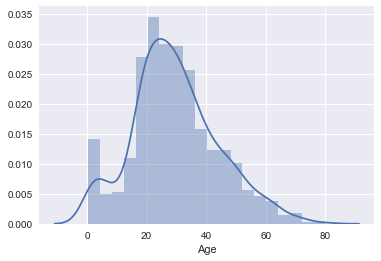

In [370]:
fig, ax = plt.subplots()
sns.distplot(train_df.Age.dropna(), ax=ax)
fig.show()

Take whatever other features are available and populated and build a model using the examples that do have values for the variable in question, then predict the value for the others. 
Populate the missing Age variable using a RandomForestClassifier model:

In [372]:
train_df_before_age = train_df.copy()
train_df_before_age.head(5) # create a copy before populating Age column

,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,FamilySize,Title
0,0,3,0,22.0,A/5 21171,7.2500,NaN,0,2,1
1,1,1,1,38.0,PC 17599,71.2833,C85,1,2,3
2,1,3,1,26.0,STON/O2. 3101282,7.9250,NaN,0,1,2
3,1,1,1,35.0,113803,53.1000,C123,0,2,3
4,0,3,0,35.0,373450,8.0500,NaN,0,1,1


In [373]:
# Option 1
# Populate missing ages using RandomForestClassifier
def setMissingAges(df):
    age_df = df[['Age','Pclass','Sex','Fare','Embarked','FamilySize','Title']]
    knownAge = age_df.loc[ (df.Age.notnull()) ]
    unknownAge = age_df.loc[ (df.Age.isnull()) ]
    # store all age values in a target array
    y = knownAge.values[:, 0]
    # store all other values in the feature array
    X = knownAge.values[:, 1::]
    # create and fit a model
    rtr = RandomForestRegressor(n_estimators=2000, n_jobs=-1)
    rtr.fit(X,y)
    # predict missing age values using the fitted model
    pred_ages = rtr.predict(unknownAge.values[:, 1::])
    # assign predictions to the full dataset
    df.loc[ (df.Age.isnull()), 'Age'] = pred_ages

setMissingAges(train_df)

In [378]:
# # Option 2
# # Another way is to generate random value using mean and standard deviation
# # get average, std, and number of NaN values in titanic_df
# average_age_df   = train_df["Age"].mean()
# std_age_df       = train_df["Age"].std()
# count_nan_age_df = train_df["Age"].isnull().sum()

# # get average, std, and number of NaN values in test_df
# average_age_test   = test_df["Age"].mean()
# std_age_test       = test_df["Age"].std()
# count_nan_age_test = test_df["Age"].isnull().sum()

# # generate random numbers between (mean - std) & (mean + std)
# rand_1 = np.random.randint(average_age_df - std_age_df, average_age_df + std_age_df, size = count_nan_age_df)
# rand_2 = np.random.randint(average_age_test - std_age_test, average_age_test + std_age_test, size = count_nan_age_test)

# # fill NaN values in Age column with random values generated
# train_df["Age"][np.isnan(train_df["Age"])] = rand_1
# test_df["Age"][np.isnan(test_df["Age"])] = rand_2

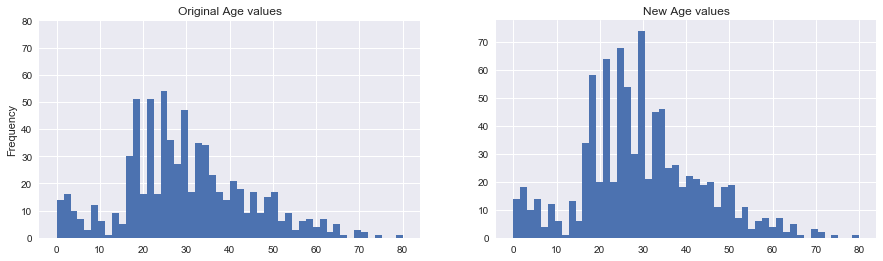

In [395]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,4))
ax1.set_title('Original Age values')
ax2.set_title('New Age values')
y_max = max(train_df['Age'].max(), train_df_before_age['Age'].max())
train_df_before_age['Age'].dropna().astype(int).plot.hist(bins=50, ax=ax1, ylim=(0,y_max))
train_df['Age'].astype(int).hist(bins=50, ax=ax2)